# Skoroszyt do rekomendacji filmu na podstawie algorytmu Machine Learning  podobienstwa kosinusowego - Analiza objaśniająca i storytelling

## SIWB, Adam Heczko, 2020/21Z


#### Główne cechy skoroszytu rekomenduj-film

Skoroszyt składa się z następujących sekcji:
* Wczytanie danych
* Analiza eksploracyjna i pre-processing
* Analiza objaśniająca i prezentacja głównych danych statystycznych, storytelling
* Zawiera więcej niż 4 wykresy
* Działa w środowisku Binder, aczkolwiek ze względów wydajnościowych wskazane jest uruchomienie na wydajnej maszynie lokalnej
* Bazuje na zbiorze danych IMDb z platformy Kaggle, https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset
* W celu predykcji podobnego filmu, wykorzystuje algorytm uczenia maszynowego (ML) "cosine similarity" zaimplementowany na podstawie biblioteki SciKit.

Skoroszyt wymaga instalacji pakietów:
* pip3 install --user numpy
* pip3 install --user pandas
* pip3 install --user matplotlib
* pip3 install --user currencyconverter
* pip3 install --user wordcloud
* pip3 install --user seaborn
* pip3 install --user nltk
* pip3 install --user sklearn # Podobienstwo kosinusowe

Skoroszyt działa w środowisku MyBinder, jednak ze względu na duży rozmiar zbioru IMDb, rekomendowane jest uruchomienie lokalne ponieważ przetwarzanie tak dużej ilości danych jest czasochłonne.

Repozytorium skoroszytu: https://github.com/miradam/siwb-rekomenduj-film

In [1]:
# Import bibliotek
# Pobranie NLTK Stopwords - potrzebne do obrobki tekstu IMDb

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from currency_converter import CurrencyConverter
import datetime
from wordcloud import WordCloud, STOPWORDS 
import textwrap
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/a/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Ładowanie danych

Proszę wybrać sposób ładowania danych wejściowych. Możne je załadować z dysku lokalnego (szybkie) bądź też z Github (wolniejsze).

### Wariant 1 - skoroszyt uruchomiony na maszynie lokalnej, ładujemy z dysku (szybkie)

In [2]:
# Ladowanie danych do Pandas Data Frame - lokalnie

data_imdb_movies = pd.read_csv('IMDb-movies.csv', low_memory=False)
data_imdb_names = pd.read_csv('IMDb-names.csv', low_memory=False)
data_imdb_title_principals = pd.read_csv('IMDb-title_principals.csv', low_memory=False)

### Wariant 2 - skoroszyt uruchomiony w MyBinder, ładujemy z Github (powolne)

In [63]:
# Ladowanie danych do Pandas Data Frame - z Github, ze względu na wielki rozmiar danych w plikach CSV
# używany jest format git-lfs
# LFS - Large File Storage , media.githubusercontent.com


data_imdb_movies = pd.read_csv('https://media.githubusercontent.com/media/miradam/siwb-rekomenduj-film/main/IMDb-movies.csv', low_memory=False)
data_imdb_names = pd.read_csv('https://media.githubusercontent.com/media/miradam/siwb-rekomenduj-film/main/IMDb-names.csv', low_memory=False)
data_imdb_title_principals = pd.read_csv('https://media.githubusercontent.com/media/miradam/siwb-rekomenduj-film/main/IMDb-title_principals.csv', low_memory=False)

In [3]:
# Sprawdzenie kolumn zbioru IMDb-movies.csv
imdb_movies = data_imdb_movies.copy()
imdb_movies.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


In [4]:
# Sprawdzenie kolumn zbioru IMDb-names.csv
# Kopiuje DataFrame zeby oryginalny obiekt nie ulegl zmianie
imdb_names = data_imdb_names.copy()
imdb_names.head()

,imdb_name_id,name,birth_name,height,bio,birth_details,date_of_birth,place_of_birth,death_details,date_of_death,place_of_death,reason_of_death,spouses_string,spouses,divorces,spouses_with_children,children
0,nm0000001,Fred Astaire,Frederic Austerlitz Jr.,177.0,"Fred Astaire was born in Omaha, Nebraska, to J...","May 10, 1899 in Omaha, Nebraska, USA",1899-05-10,"Omaha, Nebraska, USA","June 22, 1987 in Los Angeles, California, USA ...",1987-06-22,"Los Angeles, California, USA",pneumonia,Robyn Smith (27 June 1980 - 22 June 1987) (hi...,2,0,1,2
1,nm0000002,Lauren Bacall,Betty Joan Perske,174.0,Lauren Bacall was born Betty Joan Perske on Se...,"September 16, 1924 in The Bronx, New York City...",1924-09-16,"The Bronx, New York City, New York, USA","August 12, 2014 in New York City, New York, US...",2014-08-12,"New York City, New York, USA",stroke,Jason Robards (4 July 1961 - 10 September 196...,2,1,2,3
2,nm0000003,Brigitte Bardot,Brigitte Bardot,166.0,"Brigitte Bardot was born on September 28, 1934...","September 28, 1934 in Paris, France",1934-09-28,"Paris, France",NaN,NaN,NaN,NaN,Bernard d'Ormale (16 August 1992 - present)\n...,4,3,1,1
3,nm0000004,John Belushi,John Adam Belushi,170.0,"John Belushi was born in Chicago, Illinois, US...","January 24, 1949 in Chicago, Illinois, USA",1949-01-24,"Chicago, Illinois, USA","March 5, 1982 in Hollywood, Los Angeles, Calif...",1982-03-05,"Hollywood, Los Angeles, California, USA",acute cocaine and heroin intoxication,Judith Belushi-Pisano (31 December 1976 - 5 M...,1,0,0,0
4,nm0000005,Ingmar Bergman,Ernst Ingmar Bergman,179.0,"Ernst Ingmar Bergman was born July 14, 1918, t...","July 14, 1918 in Uppsala, Uppsala län, Sweden",1918-07-14,"Uppsala, Uppsala län, Sweden","July 30, 2007 in Fårö, Gotlands län, Sweden (...",2007-07-30,"Fårö, Gotlands län, Sweden",natural causes,Ingrid Bergman (11 November 1971 - 20 May 199...,5,4,5,8


In [5]:
# Sprawdzenie kolumn zbioru  IMDb-title_principals.csv
imdb_title_principals = data_imdb_title_principals.copy()
imdb_title_principals.head()

,imdb_title_id,ordering,imdb_name_id,category,job,characters
0,tt0000009,1,nm0063086,actress,NaN,"[""Miss Geraldine Holbrook (Miss Jerry)""]"
1,tt0000009,2,nm0183823,actor,NaN,"[""Mr. Hamilton""]"
2,tt0000009,3,nm1309758,actor,NaN,"[""Chauncey Depew - the Director of the New Yor..."
3,tt0000009,4,nm0085156,director,NaN,NaN
4,tt0000574,1,nm0846887,actress,NaN,"[""Kate Kelly""]"


In [29]:
# Informacja o typach danych

print(imdb_movies.info())
print('\n')
print(imdb_names.info())
print('\n')
print(imdb_title_principals.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34325 entries, 0 to 85839
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          34325 non-null  object 
 1   title                  34325 non-null  object 
 2   original_title         34325 non-null  object 
 3   year                   34325 non-null  object 
 4   date_published         34325 non-null  object 
 5   genre                  34325 non-null  object 
 6   duration               34325 non-null  int64  
 7   country                34325 non-null  object 
 8   language               33961 non-null  object 
 9   director               34289 non-null  object 
 10  writer                 34106 non-null  object 
 11  production_company     33085 non-null  object 
 12  actors                 34297 non-null  object 
 13  description            34228 non-null  object 
 14  avg_vote               34325 non-null  float64
 15  vo

## Czyszczenie i normalizacja danych

In [30]:
# Łączenie danych ze zbiorow principals, names
imdb_title_principals = pd.merge(imdb_title_principals, imdb_names[['imdb_name_id', 'name']], left_on = ['imdb_name_id'], right_on = ['imdb_name_id']) 

# Sortowanie danych i wyświetlenie
imdb_title_principals = imdb_title_principals[['imdb_title_id', 'ordering', 'imdb_name_id', 'name', 'category', 'job', 'characters']]
imdb_title_principals.head()

,imdb_title_id,ordering,imdb_name_id,name,category,job,characters
0,tt0000009,1,nm0063086,Blanche Bayliss,actress,NaN,"[""Miss Geraldine Holbrook (Miss Jerry)""]"
1,tt0000009,2,nm0183823,William Courtenay,actor,NaN,"[""Mr. Hamilton""]"
2,tt0020403,2,nm0183823,William Courtenay,actor,NaN,"[""The Minister - Guillotine Sequence""]"
3,tt0000009,3,nm1309758,Chauncey Depew,actor,NaN,"[""Chauncey Depew - the Director of the New Yor..."
4,tt0000009,4,nm0085156,Alexander Black,director,NaN,NaN


In [31]:
# Tworzenie kolumny "cinematographer" w zbiorze Movies
cinematographer_name = imdb_title_principals[imdb_title_principals['category']=='cinematographer'].reset_index()
cinematographer_name.rename(columns={'name' : 'cinematographer'}, inplace = True)
imdb_movies = pd.merge(imdb_movies, cinematographer_name[['imdb_title_id', 'cinematographer']], left_on = 'imdb_title_id', right_on = 'imdb_title_id', how = 'left')

cinematographer_name.head()
# imdb_title_principals.head()
# imdb_movies.head()

,index,imdb_title_id,ordering,imdb_name_id,cinematographer,category,job,characters
0,14,tt0000574,10,nm0675239,Orrie Perry,cinematographer,NaN,NaN
1,23,tt0001892,7,nm0423762,Adam Johansen,cinematographer,NaN,NaN
2,24,tt0001892,8,nm0005869,Guido Seeber,cinematographer,NaN,NaN
3,25,tt0003419,9,nm0005869,Guido Seeber,cinematographer,NaN,NaN
4,26,tt0004026,6,nm0005869,Guido Seeber,cinematographer,NaN,NaN


In [32]:
# Łączenie danych do kolumny "cinematographer" i normalizacja
duplicated_data = imdb_movies[imdb_movies['imdb_title_id'].duplicated(keep = False)]
multiple_names_cinematographer = duplicated_data.groupby('imdb_title_id')['cinematographer'].apply(', '.join).reset_index()
duplicated_data.drop(['cinematographer'], axis = 1, inplace = True)
duplicated_data.drop_duplicates(subset=['imdb_title_id'], inplace = True)
data_multiple_names = pd.merge(duplicated_data, multiple_names_cinematographer[['imdb_title_id', 'cinematographer']], left_on = 'imdb_title_id', right_on = 'imdb_title_id')
data_multiple_names[['imdb_title_id', 'cinematographer']].head()

,imdb_title_id,cinematographer
0,tt0004134,"Dal Clawson, George W. Hill"
1,tt0005149,"Robert Newhard, Joseph H. August"
2,tt0007340,"King D. Gray, Stephen S. Norton"
3,tt0007755,"John W. Brown, Ben F. Reynolds"
4,tt0008196,"Walter Stradling, Charles Rosher"


In [33]:
# Usuwanie zduplikowanych danych z kolumny 'cinematographer'
imdb_movies.drop_duplicates(subset=['imdb_title_id'], keep = False, inplace = True)
imdb_movies = pd.concat((imdb_movies, data_multiple_names), sort = False).sort_values('imdb_title_id')

# Zmiana położenia kolumny 'cinematographer'
cols = imdb_movies.columns.tolist()
cols = cols[0:13] + cols[-1:] + cols [13:-1]
imdb_movies = imdb_movies[cols]
imdb_movies.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,cinematographer,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,NaN,The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,NaN,The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
2,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,...,George K. Hollister,"An account of the life of Jesus Christ, based ...",5.7,484,NaN,NaN,NaN,NaN,13.0,5.0
3,tt0002461,Richard III,Richard III,1912,1912-10-15,Drama,55,"France, USA",English,"André Calmettes, James Keane",...,NaN,Richard of Gloucester uses manipulation and mu...,5.5,225,$ 30000,NaN,NaN,NaN,8.0,1.0
4,tt0003167,Amore di madre,"Home, Sweet Home",1914,1914-05-17,Drama,55,USA,English,D.W. Griffith,...,G.W. Bitzer,John Howard Payne at his most miserable point ...,5.8,187,NaN,NaN,NaN,NaN,6.0,NaN


In [34]:
# Filtrowanie danych. Pozostawienie rekordów dotyczących wyłącznie filmów wyprodukowanych w USA.
# Można również łatwo pozostawić filmy NIE wyprodukowane w USA poprzez zmianę warunku str.contains
imdb_movies['country'].fillna('', inplace = True)
imdb_movies = imdb_movies[imdb_movies['country'].str.contains('USA')]

In [35]:
# Czyszczenie i normalizacja danych w zakresie waluty i konwersja na USD 
imdb_movies['budget_currency'] = imdb_movies['budget'].str.split(' ', expand = True)[0]
imdb_movies['budget_currency'] = imdb_movies['budget_currency'].str.replace('$', 'USD')
imdb_movies['budget'] = imdb_movies['budget'].str.split(' ', expand = True)[1]
imdb_movies['budget'] = pd.to_numeric(imdb_movies['budget'], errors='coerce')

# Czyszczenie i normalizacja danych związanych z przychodami filmu - przeliczenie worlwide_gross_income
# na USD
imdb_movies['worlwide_gross_income_currency'] = imdb_movies['worlwide_gross_income'].str.split(' ', expand = True)[0]
imdb_movies['worlwide_gross_income_currency'] = imdb_movies['worlwide_gross_income_currency'].str.replace('$', 'USD')
imdb_movies['worlwide_gross_income'] = imdb_movies['worlwide_gross_income'].str.split(' ', expand = True)[1]
imdb_movies['worlwide_gross_income'] = pd.to_numeric(imdb_movies['worlwide_gross_income'], errors='coerce')

# Przygotowanie kolumny Konwersja usa_gross_income_currency do konwersji na typ numeryczny 
imdb_movies['usa_gross_income_currency'] = imdb_movies['usa_gross_income'].str.split(' ', expand = True)[0]
imdb_movies['usa_gross_income_currency'] = imdb_movies['usa_gross_income_currency'].str.replace('$', 'USD')
imdb_movies['usa_gross_income'] = imdb_movies['usa_gross_income'].str.split(' ', expand = True)[1]
imdb_movies['usa_gross_income'] = pd.to_numeric(imdb_movies['usa_gross_income'], errors='coerce')


<ipython-input-35-4ce2eb479ade>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  imdb_movies['budget_currency'] = imdb_movies['budget_currency'].str.replace('$', 'USD')
<ipython-input-35-4ce2eb479ade>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  imdb_movies['worlwide_gross_income_currency'] = imdb_movies['worlwide_gross_income_currency'].str.replace('$', 'USD')
<ipython-input-35-4ce2eb479ade>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  imdb_movies['usa_gross_income_currency'] = imdb_movies['usa_gross_income_curre

#### Uwaga! poniższe operacje są długotrwałe ze względu na rozmiar danych i fakt że operujemy na polach tekstowych.

In [36]:
# Konwersja danych tekstowych na typ liczbowy - ujednolicenie do USD

c = CurrencyConverter()
for i in range(imdb_movies.shape[0]):
    # budget column
    if (imdb_movies['budget_currency'].iloc[i] in c.currencies):
        imdb_movies['budget'].iloc[i] = c.convert(imdb_movies['budget'].iloc[i], imdb_movies['budget_currency'].iloc[i], 'USD')
    else :
        imdb_movies['budget'].iloc[i] = np.nan
   
    # worlwide_gross_income column   
    if (imdb_movies['worlwide_gross_income_currency'].iloc[i] in c.currencies):
        imdb_movies['worlwide_gross_income'].iloc[i] = c.convert(imdb_movies['worlwide_gross_income'].iloc[i], 
                                                            imdb_movies['worlwide_gross_income_currency'].iloc[i], 'USD', )
    else :
        imdb_movies['worlwide_gross_income'].iloc[i] = np.nan
    
    # usa_gross_income column   
    if (imdb_movies['usa_gross_income_currency'].iloc[i] in c.currencies):
        imdb_movies['usa_gross_income'].iloc[i] = c.convert(imdb_movies['usa_gross_income'].iloc[i], 
                                                       imdb_movies['usa_gross_income_currency'].iloc[i], 'USD', 
                                                       )
    else :
        imdb_movies['usa_gross_income'].iloc[i] = np.nan


# Analiza eksploracyjna

### Analiza danych liczbowych

In [37]:
num_data = ['duration', 'avg_vote', 'votes', 'budget', 'usa_gross_income', 'worlwide_gross_income', 
            'metascore', 'reviews_from_users', 'reviews_from_critics']
imdb_movies[num_data].describe()

,duration,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
count,34325.000000,34325.000000,3.432500e+04,1.361000e+04,1.058700e+04,1.134000e+04,9508.000000,33931.000000,32250.000000
mean,94.605273,5.609413,1.999168e+04,1.616476e+07,2.745402e+07,5.234298e+07,53.079617,82.781203,41.832031
std,18.796947,1.273202,8.161522e+04,3.125879e+07,5.607265e+07,1.389903e+08,17.807689,252.584710,78.525503
min,42.000000,1.100000,9.900000e+01,0.000000e+00,3.000000e+01,1.600000e+01,1.000000,1.000000,1.000000
25%,85.000000,4.800000,2.520000e+02,6.700000e+05,2.813985e+05,2.228240e+05,40.000000,8.000000,4.000000
50%,92.000000,5.800000,7.380000e+02,3.341750e+06,6.014341e+06,5.779699e+06,53.000000,19.000000,12.000000
75%,102.000000,6.500000,4.561000e+03,1.800000e+07,3.072612e+07,3.915875e+07,66.000000,54.000000,39.000000
max,398.000000,9.700000,2.278845e+06,3.560000e+08,9.366622e+08,2.797801e+09,100.000000,10472.000000,999.000000


### Analiza danych wg kategorii

#### Which Decade Has Release Most Movies and Highest Average Vote (Rating)

In [38]:
# Zmiana w kolumnie 'year'
imdb_movies['year'].replace('TV Movie 2019', 2019, inplace = True)
imdb_movies['year'] = imdb_movies['year'].astype(int)

# Grupowanie po kolumnie 'decades'
movies_by_decades = imdb_movies[['imdb_title_id', 'original_title', 'year','avg_vote', 'votes']]
decades = movies_by_decades['year']//10*10
decades = decades.astype(str)+' - '+ (decades+9).astype(str)
decades_column = pd.DataFrame(decades)
movies_by_decades.insert(3, 'decades', decades_column)
movies_by_decades.head()

,imdb_title_id,original_title,year,decades,avg_vote,votes
0,tt0000009,Miss Jerry,1894,1890 - 1899,5.9,154
1,tt0002101,Cleopatra,1912,1910 - 1919,5.2,446
2,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...",1912,1910 - 1919,5.7,484
3,tt0002461,Richard III,1912,1910 - 1919,5.5,225
4,tt0003167,"Home, Sweet Home",1914,1910 - 1919,5.8,187


# Analiza objaśniająca i storytelling 

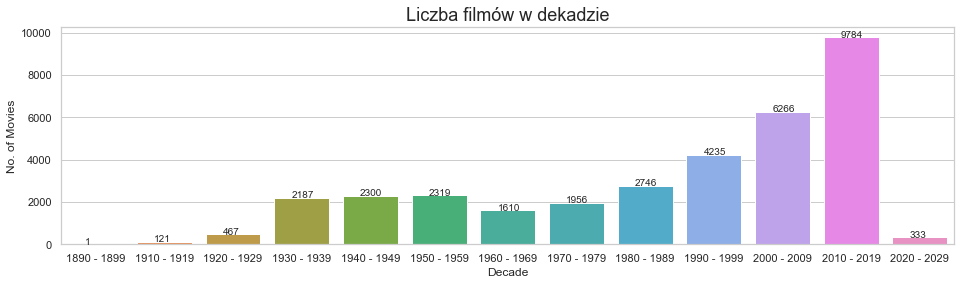

In [39]:
# Wizualizacja - wykres typu barchart

max_width = 15
fig, ax = plt.subplots(figsize = (16,4))
decades = movies_by_decades.groupby('decades')['imdb_title_id'].count().index
count = movies_by_decades.groupby('decades')['imdb_title_id'].count()
sns.barplot(ax = ax, x = decades, y = count)
ax.set_title('Liczba filmów w dekadzie', fontsize = 18)
ax.set_xlabel('Decade')
for index,count in enumerate(count.astype(int)):
       ax.text(x=index-0.15 , y =count+1 , s=f"{count}" , fontdict=dict(fontsize=10))
ax.set_ylabel('No. of Movies')
plt.show()

Widać wyraźny, znaczący przyrost liczby wyprodukowanych filmów.

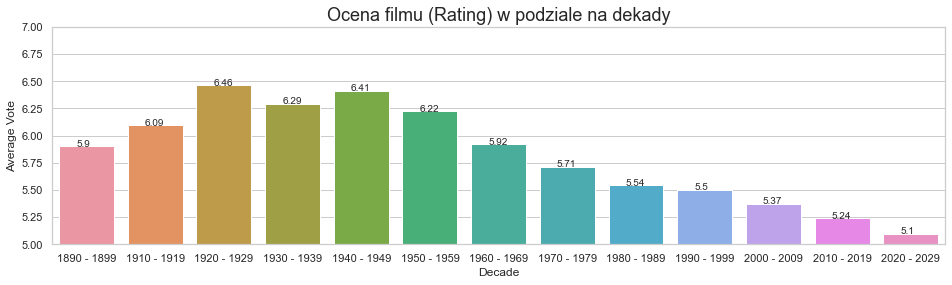

In [40]:
# Wizualizacja oceny filmu, w rozbiciu na dekady

max_width = 15
fig, ax = plt.subplots(figsize = (16,4))
decades = movies_by_decades.groupby('decades')['avg_vote'].mean().index
avg_vote = movies_by_decades.groupby('decades')['avg_vote'].mean()
sns.barplot(ax = ax, x = decades, y = avg_vote)
ax.set_title('Ocena filmu (Rating) w podziale na dekady', fontsize = 18)
ax.set_xlabel('Decade')
for index,avg_vote in enumerate(np.round(avg_vote, 2)):
       ax.text(x=index-0.15 , y =avg_vote+0 , s=f"{avg_vote}" , fontdict=dict(fontsize=10))
ax.set_ylabel('Average Vote')
ax.set_ylim((5, 7))

plt.show()

Widać korelację pomiędzy średnią jakością filmów a ilością wyprodukowanych.

#### Analiza w podziale na miesiące

In [41]:
# Preprocessing

imdb_movies['date_published'].replace('TV Movie 2019', 2019, inplace = True)
movies_published = imdb_movies[['imdb_title_id', 'original_title', 'genre', 'date_published']]
movies_published['month_published'] = [month[5:7] for month in movies_published['date_published'].astype(str)]

# Zamiana pustych wartości na NaN
movies_published['month_published'][movies_published['month_published']==''] = np.nan
movies_published.head()

,imdb_title_id,original_title,genre,date_published,month_published
0,tt0000009,Miss Jerry,Romance,1894-10-09,10
1,tt0002101,Cleopatra,"Drama, History",1912-11-13,11
2,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","Biography, Drama",1913,NaN
3,tt0002461,Richard III,Drama,1912-10-15,10
4,tt0003167,"Home, Sweet Home",Drama,1914-05-17,05


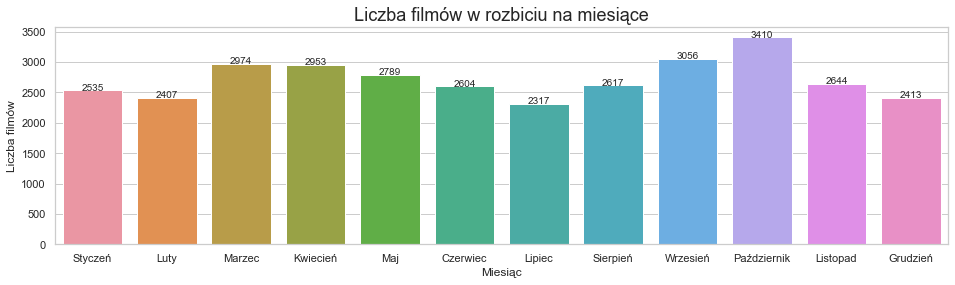

In [42]:
# Wizualizacja w rozbiciu na miesiące

max_width = 15
fig, ax = plt.subplots(figsize = (16,4))
months_published = movies_published.groupby('month_published')['imdb_title_id'].count().index
count_movies = movies_published.groupby('month_published')['imdb_title_id'].count()
sns.barplot(ax = ax, x = months_published, y = count_movies)
ax.set_title('Liczba filmów w rozbiciu na miesiące', fontsize = 18)
ax.set_xlabel('Miesiąc')
ax.set_ylabel('Liczba filmów')
for index,count_movies in enumerate(count_movies):
       ax.text(x=index-0.15 , y =count_movies+0 , s=f"{count_movies}" , fontdict=dict(fontsize=10))
ax.set_xticklabels(['Styczeń', 'Luty', 'Marzec', 'Kwiecień', 'Maj', 'Czerwiec'
                    , 'Lipiec', 'Sierpień', 'Wrzesień', 'Październik', 'Listopad', 'Grudzień'])

plt.show()

### Analiza gatunków filmów


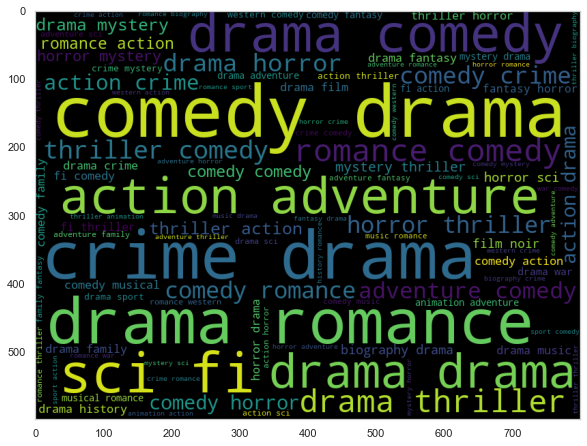

In [43]:
# Preprocessing

comment_words = ''
stop_words = set(STOPWORDS)

for val in imdb_movies['genre']:
    val = str(val)
    tokens = val.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 600, background_color = 'black'
                      , stopwords = stop_words, min_font_size = 10).generate(comment_words)

fig, ax = plt.subplots(figsize = (8, 6))
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
plt.show()

Widać wyraźną przewagę filmów gatunku Komedia, dramat, romans, również kryminalne są popularne.

### Podział Gatunek względem Ocena

In [44]:
# Preprocessing i podział kolumn gatunek, bo film może należeć do kilku gatunków jednocześnie

movies_genre = imdb_movies[['imdb_title_id', 'original_title', 'genre', 'avg_vote']]
movies_genre['genre'] = movies_genre['genre'].astype('str')

genre_split = pd.DataFrame(movies_genre['genre'].str.split(',').tolist(), index=movies_genre['imdb_title_id']).stack()
genre_split = genre_split.reset_index(['imdb_title_id'])
genre_split.columns = ['imdb_title_id', 'genre_split']
movies_genre_split = pd.merge(genre_split, movies_genre[['imdb_title_id', 'original_title', 'avg_vote']],
                              left_on = 'imdb_title_id', right_on = 'imdb_title_id')
movies_genre_split['genre_split'] = movies_genre_split['genre_split'].str.lstrip(' ').str.rstrip(' ')
movies_genre_split.head()

,imdb_title_id,genre_split,original_title,avg_vote
0,tt0000009,Romance,Miss Jerry,5.9
1,tt0002101,Drama,Cleopatra,5.2
2,tt0002101,History,Cleopatra,5.2
3,tt0002199,Biography,"From the Manger to the Cross; or, Jesus of Naz...",5.7
4,tt0002199,Drama,"From the Manger to the Cross; or, Jesus of Naz...",5.7


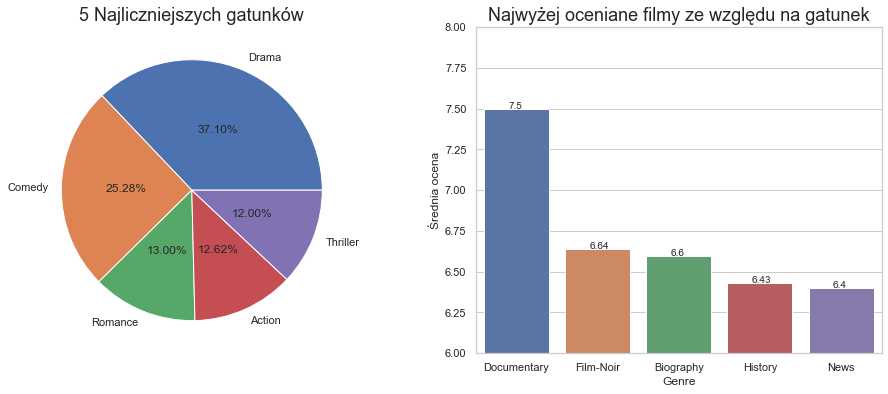

In [52]:
# Wykres dla 5 Najliczniejszych gatunków

fig, ax = plt.subplots(1, 2, figsize = (16,6))

genres = movies_genre_split.groupby('genre_split')['imdb_title_id'].count().sort_values(ascending = False).index[0:5]
count_movies = movies_genre_split.groupby('genre_split')['imdb_title_id'].count().sort_values(ascending = False)[0:5]
ax[0].pie(x=count_movies, autopct="%.2f%%", labels=genres, pctdistance=0.5)
ax[0].set_title('5 Najliczniejszych gatunków', fontsize = 18)

genres = movies_genre_split.groupby('genre_split')['avg_vote'].mean().sort_values(ascending = False).index[0:5]
avg_votes = movies_genre_split.groupby('genre_split')['avg_vote'].mean().sort_values(ascending = False)[0:5]
sns.barplot(ax = ax[1], x = genres, y = avg_votes)
ax[1].set_title('Najwyżej oceniane filmy ze względu na gatunek', fontsize = 18)
ax[1].set_xlabel('Genre')
for index,avg_votes in enumerate(round(avg_votes, 2)):
    ax[1].text(x=index-0.1 , y =avg_votes+0 , s=f"{avg_votes}" , fontdict=dict(fontsize=10))
ax[1].set_ylabel('Średnia ocena')
ax[1].set_ylim(6, 8)

plt.show()

Widać że najwyższe oceny otrzymały filmy dokumentalne.

#### Który scenarzysta napisał najwięcej scenariuszy o najwyższej ocenie

In [55]:
# Preprocessing

movies_writer = imdb_movies[['imdb_title_id', 'original_title', 'writer', 'avg_vote']]
movies_writer['writer'] = movies_writer['writer'].astype('str')

writer_split = pd.DataFrame(movies_writer['writer'].str.split(',').tolist(), index=movies_writer['imdb_title_id']).stack()
writer_split = writer_split.reset_index(['imdb_title_id'])
writer_split.columns = ['imdb_title_id', 'writer_split']
movies_writer_split = pd.merge(writer_split, movies_writer[['imdb_title_id', 'original_title', 'avg_vote']],
                              left_on = 'imdb_title_id', right_on = 'imdb_title_id')
movies_writer_split['writer_split'] = movies_writer_split['writer_split'].str.lstrip(' ').str.rstrip(' ')
gb_writer = movies_writer_split.groupby('writer_split').agg({ 'imdb_title_id' : ['count'], 'avg_vote': ['mean']})
gb_writer.drop(gb_writer[gb_writer.index == 'nan'].index, inplace = True)
gb_writer.head()

,imdb_title_id,avg_vote
,count,mean
writer_split,,
'A.J.' Marriot,1,7.2
'Evil' Ted Smith,1,4.0
'Weird Al' Yankovic,1,7.0
50 Cent,2,4.6
A. Channing Edington,1,5.7


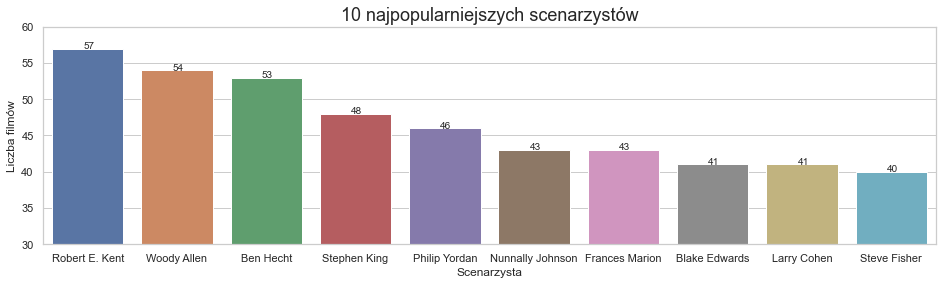

In [57]:
# Wykres 10 najpopularniejszych scenarzystów

max_width = 15
fig, ax = plt.subplots(figsize = (16,4))

writers = gb_writer[('imdb_title_id', 'count')].sort_values(ascending = False)[0:10].index
count_movies = gb_writer[('imdb_title_id', 'count')].sort_values(ascending = False)[0:10]

sns.barplot(ax = ax, x = writers, y = count_movies)
ax.set_title('10 najpopularniejszych scenarzystów', fontsize = 18)
ax.set_xlabel('Scenarzysta')
for index,count_movies in enumerate(count_movies):
    ax.text(x=index-0.05 , y =count_movies+0 , s=f"{count_movies}" , fontdict=dict(fontsize=10))
ax.set_ylabel('Liczba filmów')
ax.set_ylim(30, 60)
plt.show()

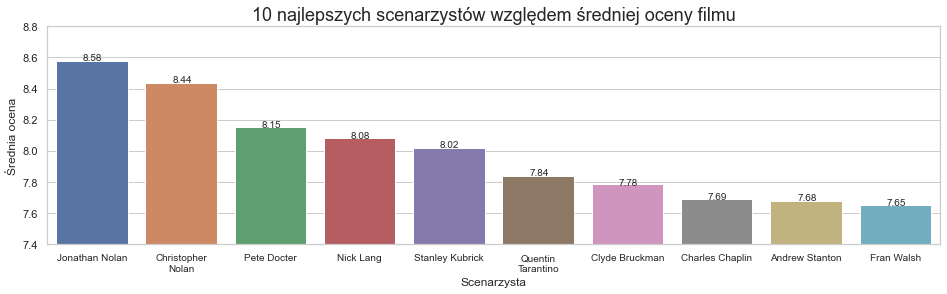

In [58]:
# 10 scenarzystów w rozbiciu na ocenę filmu

max_width = 15
fig, ax = plt.subplots(figsize = (16,4))

# Specification : at least have write 5 movies
mask = movies_writer_split.groupby('writer_split')['imdb_title_id'].count() >= 5
writers = gb_writer.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10].index
avg_vote = gb_writer.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10]

sns.barplot(ax = ax, x = writers, y = avg_vote)
ax.set_title('10 najlepszych scenarzystów względem średniej oceny filmu', fontsize = 18)
ax.set_xlabel('Scenarzysta')
ax.set_xticklabels((textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels()), fontsize = 10)
for index,avg_vote in enumerate(round(avg_vote, 2)):
    ax.text(x=index-0.1 , y =avg_vote+0 , s=f"{avg_vote}" , fontdict=dict(fontsize=10))
ax.set_ylabel('Średnia ocena')
ax.set_ylim(7.4, 8.8)
plt.show()

#### Analizy w rozbiciu na aktorów 

In [59]:
# Preprocessing

movies_actor = imdb_movies[['imdb_title_id', 'original_title', 'actors', 'avg_vote']]
movies_actor['actors'] = movies_actor['actors'].astype('str')

actor_split = pd.DataFrame(movies_actor['actors'].str.split(',').tolist(), index=movies_actor['imdb_title_id']).stack()
actor_split = actor_split.reset_index(['imdb_title_id'])
actor_split.columns = ['imdb_title_id', 'actor_split']
movies_actor_split = pd.merge(actor_split, movies_actor[['imdb_title_id', 'original_title', 'avg_vote']],
                              left_on = 'imdb_title_id', right_on = 'imdb_title_id')
movies_actor_split['actor_split'] = movies_actor_split['actor_split'].str.lstrip(' ').str.rstrip(' ')
gb_actor = movies_actor_split.groupby('actor_split').agg({ 'imdb_title_id' : ['count'], 'avg_vote': ['mean']})
gb_actor.drop((gb_actor[gb_actor.index == 'nan'].index), inplace = True)
gb_actor.head()

,imdb_title_id,avg_vote
,count,mean
actor_split,,
'Baby' Carmen De Rue,3,5.166667
'Big Al' Solomon,1,3.400000
'Big Jack' Provan,1,6.000000
'Big Walter' Price,1,5.800000
'Big' Jack Little,1,4.300000


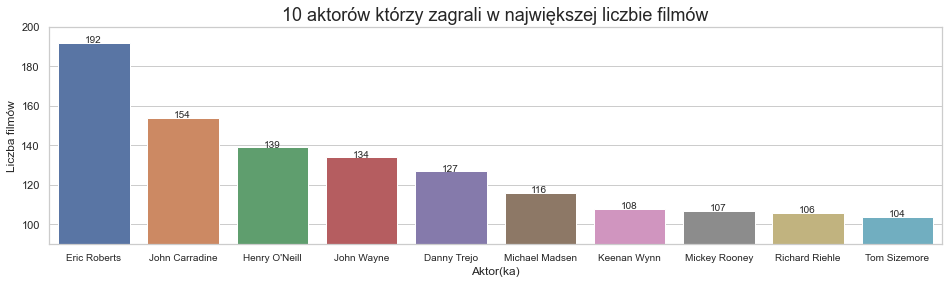

In [62]:
# 10 aktorów którzy zagrali w największej liczbie filmów

max_width = 15
fig, ax = plt.subplots(figsize = (16,4))

actor = gb_actor[('imdb_title_id', 'count')].sort_values(ascending = False)[0:10].index
count_movies = gb_actor[('imdb_title_id', 'count')].sort_values(ascending = False)[0:10]

sns.barplot(ax = ax, x = actor, y = count_movies)
ax.set_title('10 aktorów którzy zagrali w największej liczbie filmów', fontsize = 18)
ax.set_xlabel('Aktor(ka)')
ax.set_xticklabels((textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels()), fontsize = 10)
for index,count_movies in enumerate(count_movies):
    ax.text(x=index-0.1 , y =count_movies+0 , s=f"{count_movies}" , fontdict=dict(fontsize=10))
ax.set_ylabel('Liczba filmów')
ax.set_ylim(90, 200)
plt.show()

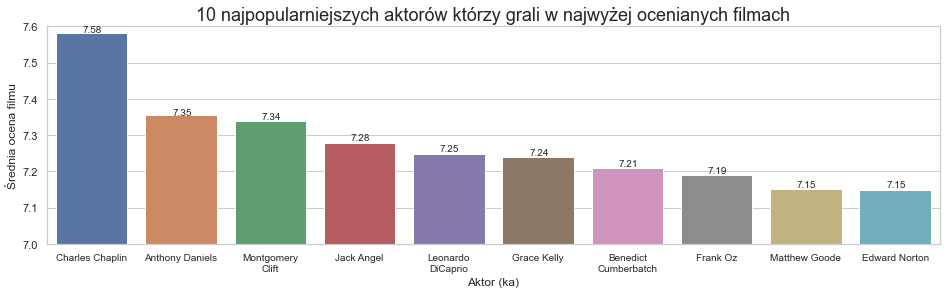

In [63]:
# 10 najpopularniejszych aktorów którzy grali w najwyżej ocenianych filmach

max_width = 15
fig, ax = plt.subplots(figsize = (16,4))

# Filtr dla tych którzy zagrali w co najmniej 10 filmach
mask = movies_actor_split.groupby('actor_split')['imdb_title_id'].count() >= 10
actor = gb_actor.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10].index
avg_vote = gb_actor.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10]

sns.barplot(ax = ax, x = actor, y = avg_vote)
ax.set_title('10 najpopularniejszych aktorów którzy grali w najwyżej ocenianych filmach', fontsize = 18)
ax.set_xlabel('Aktor (ka)')
ax.set_xticklabels((textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels()), fontsize = 10)
for index,avg_vote in enumerate(round(avg_vote, 2)):
    ax.text(x=index-0.1 , y =avg_vote+0.005 , s=f"{avg_vote}" , fontdict=dict(fontsize=10))
ax.set_ylabel('Średnia ocena filmu')
ax.set_ylim(7, 7.6)
plt.show()

# Element Machine Learning - Rekomendacja tytułu filmu do obejrzenia na podstawie podanego tytułu

Algorytm rekomendacji filmu bazuje na następujących danych:
* original_title - podana nazwa filmu względem którego liczona jest rekomendacja kolejnego filmu do obejrzenia
* genre - gatunek
* director - reżyser
* actors - obsada
* description - opis filmu

Skororszyt stara się dobrać na podstawie powyższych danych, przy pomocy algorytmu podobieństwa kosinusowego, film podobny do podanego tzn. 'original title'


In [64]:
data_recsys=imdb_movies[['original_title', 'genre', 'director', 'actors', 'description']].reset_index(drop = True)
data_recsys.head()

,original_title,genre,director,actors,description
0,Miss Jerry,Romance,Alexander Black,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.
1,Cleopatra,"Drama, History",Charles L. Gaskill,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...
2,"From the Manger to the Cross; or, Jesus of Naz...","Biography, Drama",Sidney Olcott,"R. Henderson Bland, Percy Dyer, Gene Gauntier,...","An account of the life of Jesus Christ, based ..."
3,Richard III,Drama,"André Calmettes, James Keane","Robert Gemp, Frederick Warde, Albert Gardner, ...",Richard of Gloucester uses manipulation and mu...
4,"Home, Sweet Home",Drama,D.W. Griffith,"Henry B. Walthall, Josephine Crowell, Lillian ...",John Howard Payne at his most miserable point ...


In [65]:
# Preprocessing

data_recsys.set_index('original_title', inplace = True)

data_recsys['genre'] = data_recsys['genre'].fillna('').astype('str').str.lower()
data_recsys['genre'] = data_recsys['genre'].str.split(',')

data_recsys['director'] = data_recsys['director'].fillna('').astype('str').str.lower()
data_recsys['director'] = data_recsys['director'].str.split(',')

data_recsys['actors'] = data_recsys['actors'].fillna('').astype('str').str.lower()
data_recsys['actors'] = data_recsys['actors'].str.split(',')

#### Uwaga! Poniższe operacje są czasochłonne ze względu na operacje tekstowe na dużym zbiorze danych.

In [66]:
# Preprocessing

data_recsys['description'] = data_recsys['description'].fillna('').astype('str').str.lower()
data_recsys['description'] = data_recsys['description'].str.translate(str.maketrans('', '', string.punctuation))

#from nltk.corpus import stopwords
listStopwords = set(stopwords.words('english'))
filtered = []
ps = PorterStemmer() 
for i, text in enumerate(data_recsys['description'].str.split()):
    for word in text:
        # Filtering/Removing stopwords in the text
        if word not in listStopwords:
            # Stemming words
            word_stemmed = ps.stem(word)
            filtered.append(word_stemmed)
    data_recsys['description'][i] = filtered
    filtered = []

In [67]:
# Tworzenie nowej kolumny 'bunch_of_words' która zawiera słowa kluczowe z pozostałych kolumn

data_recsys['bunch_of_words'] = ''
for i, text in data_recsys.iterrows():
    words = ''
    for col in data_recsys.columns:
        words = words + ' '.join(text[col]) + ' '
    data_recsys['bunch_of_words'][i] = words

In [68]:
data_recsys.head()

,genre,director,actors,description,bunch_of_words
original_title,,,,,
Miss Jerry,[romance],[alexander black],"[blanche bayliss, william courtenay, chaunce...","[adventur, femal, report, 1890]",romance alexander black blanche bayliss willi...
Cleopatra,"[drama, history]",[charles l. gaskill],"[helen gardner, pearl sindelar, miss fieldin...","[fabl, queen, egypt, affair, roman, gener, mar...",biography drama history joseph l. mankiewicz...
"From the Manger to the Cross; or, Jesus of Nazareth","[biography, drama]",[sidney olcott],"[r. henderson bland, percy dyer, gene gaunti...","[account, life, jesu, christ, base, book, new,...",biography drama sidney olcott r. henderson bl...
Richard III,[drama],"[andré calmettes, james keane]","[robert gemp, frederick warde, albert gardne...","[richard, gloucest, use, manipul, murder, gain...",drama andré calmettes james keane robert gemp...
"Home, Sweet Home",[drama],[d.w. griffith],"[henry b. walthall, josephine crowell, lilli...","[john, howard, payn, miser, point, life, write...",drama d.w. griffith henry b. walthall josephi...


In [69]:
# Konwersja 'bunch of words' do wektora słowo/wartość (CountVectorizer)

count = CountVectorizer()
count_matrix = count.fit_transform(data_recsys['bunch_of_words']).astype(np.uint8)

In [70]:
# Kasujemy niepotrzebne już dane, pozwala zaoszczędzić pamięć
del data_imdb_names
del data_imdb_title_principals

## Obliczenie podobieństwa kosinusowego 

Podobieństwo kosinusowe jest miarą używaną do mierzenia stopnia podobieństwa dokumentów niezależnie od ich wielkości.

#### Uwaga! Poniższa operacja jest czasochłonna.

In [72]:
# Obliczenie podobieństwa kosinusowego - Cosine Similarity
# W małych porcjach chunk_size

chunk_size = 500 
matrix_len = count_matrix.shape[0]

# Obliczenie w porcji
def similarity_cosine_by_chunk(start, end):
    if end > matrix_len:
        end = matrix_len
    return cosine_similarity(X=count_matrix[start:end], Y=count_matrix)
cosine_similarity_all = []
i=0
for chunk_start in range(0, matrix_len, chunk_size):
    
    # Inicjalizacja pierwszej porcji
    if i == 0: 
        cosine_sim = similarity_cosine_by_chunk(chunk_start, chunk_start+chunk_size)
    
    # Inicjalizacja kolejnej porcji, następnie łączenie porcji tak aż wszystki porcje sa połączone
    else :
        cosine_similarity_chunk= similarity_cosine_by_chunk(chunk_start, chunk_start+chunk_size)
        # Użycie typu float32
        cosine_sim = np.concatenate((cosine_sim.astype(np.float32), cosine_similarity_chunk.astype(np.float32)))
    
    # Zmiana wartości i != 0 do wykonania polecenia else:
    # (nie potrzebujemy więcej wykonywać polecenia if: jeśli pierwsza porcja została już zainicjalizowana
    i= 1

In [74]:
# Funkcja zwracająca 10 rekomendacji bazując na podanym tytule

# Utworzenie Pandas Index
index_movies = pd.Series(data_recsys.index)

# Funkcja poszukiwania rekomendacji
def recommendation_movies(title, cosine_sim = cosine_sim):
    recommended_movies = []
    index_movie_input = index_movies[index_movies == title].index[0]
    score_movies = pd.Series(cosine_sim[index_movie_input]).sort_values(ascending = False)
    top_10_index_movies = list(score_movies.iloc[1:11].index)
    # Get movies title and year by index (top 10 movies)
    for i in top_10_index_movies:
        recommended_movies.append(imdb_movies['original_title'].iloc[i] + ' (' + str(imdb_movies['year'].iloc[i]) + ')')
    return recommended_movies

### Obliczenie rekomendacji

W celu obliczenia rekomendacji należy podać tytuł istniejącego w bazie IMDb filmu, na podstawie którego za pomocą algorytmu ML zostanie podana rekomendacja kolejnego tytułu do obejrzenia.

In [75]:
# recommendation_movies('The Dark Knight')
recommendation_movies('Hamburger Hill')

['Journey to Shiloh (1968)',
 'Haywire (2011)',
 'Shake Hands with the Devil (1959)',
 'Kid (1990)',
 'Merchant of Death (1997)',
 'Frisk (1995)',
 'Ablaze (2001)',
 'Robot Ninja (1989)',
 'A Boy and His Dog (1975)',
 'Miles Ahead (2015)']

# Bibliografia

* https://towardsdatascience.com/understanding-cosine-similarity-and-its-application-fd42f585296a
* https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
* https://en.wikipedia.org/wiki/Cosine_similarity
